### new script for snRNA

In [1]:
# import what is needed
import sys
print(sys.executable)
### load packages
import anndata as ad # for annotating with obs and var
import scanpy as sc # core sc package
import pandas as pd # dataframes
#import harmonypy as hm # for batch effect correction
#import scanorama # for batch effect correction 
import scvi as scvi # for doublet handling
import seaborn as sns # plots
import matplotlib.pyplot as plt # plots
import scipy.sparse as sp
from scipy.sparse import csr_matrix # matrices
import sys # system
import os # system
import glob # global system
from os import listdir
from os.path import isfile, join
#import torch # for training scvi
import random
import numpy as np # numbers
from scipy.stats import median_abs_deviation as mad
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import celltypist
from celltypist import train

/software/cellgen/team274/lr26/miniforge3/envs/my-python/bin/python


/software/cellgen/team274/lr26/miniforge3/envs/my-python/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/software/cellgen/team274/lr26/miniforge3/envs/my-python/lib/python3.10/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [2]:
np.random.seed(42)  # Set seed for scrublet

In [3]:
raw_data_dir = "/lustre/scratch125/cellgen/behjati/lr26/snRNA/"

In [ ]:
def get_sample_id(matrix_dir):
    # Get folder name, e.g. "CG_SB_NB13960948_filtered_feature_bc_matrix"
    foldername = os.path.basename(matrix_dir)
    # Remove suffix
    sample_id = foldername.replace("_filtered_feature_bc_matrix", "")
    return sample_id

def load_and_annotate(matrix_dir):
    sample_id = get_sample_id(matrix_dir)
    
    adata = sc.read_10x_mtx(
        matrix_dir,
        var_names='gene_symbols',
        cache=False
    )
    
    # Annotate metadata
    adata.obs["SampleID"] = sample_id
    adata.obs["Barcode"] = adata.obs_names.tolist()
    adata.obs["CellID"] = [f"{sample_id}_{bc}" for bc in adata.obs_names]
    adata.obs_names = adata.obs["CellID"].tolist()
    
    return adata

# Collect all filtered_feature_bc_matrix dirs directly under raw_data_dir
matrix_dirs = [
    os.path.join(raw_data_dir, d)
    for d in os.listdir(raw_data_dir)
    if d.endswith("_filtered_feature_bc_matrix") and os.path.isdir(os.path.join(raw_data_dir, d))
]

print(f"Found {len(matrix_dirs)} samples.")

# Load all samples into a list of AnnData objects
adatas = [load_and_annotate(d) for d in matrix_dirs]

# Now you can run scrublet on each adata individually, then merge if you want


In [ ]:
def run_scrublet(adata):
    try:
        sc.pp.scrublet(
            adata,
            threshold=None,  # auto threshold
            verbose=True
        )
        # Map boolean doublet prediction to labels
        adata.obs["scrublet"] = adata.obs["predicted_doublets"].map({True: "doublet", False: "singlet"})
        # Rename doublet score column
        adata.obs.rename(columns={"doublet_score": "scrublet_score"}, inplace=True)
    except Exception as e:
        print(f"Scrublet failed for sample {adata.obs['SampleID'][0]}: {e}")
    return adata

# Assuming you have a list of adatas loaded (adatas)

for i, adata in enumerate(adatas):
    print(f"Running Scrublet on sample {adata.obs['SampleID'][0]} ({i+1}/{len(adatas)})...")
    adatas[i] = run_scrublet(adata)

# Merge all into one AnnData
print("Merging all samples...")
adata_merged = adatas[0].concatenate(*adatas[1:], index_unique="-")

print(f"Merged dataset has {adata_merged.n_obs} cells and {adata_merged.n_vars} genes.")

In [ ]:
adata_merged

In [ ]:
print(adata_merged) # how does it look
print(adata_merged.obs.head()) #cells
print(adata_merged.var.head())
print(adata_merged.shape)  # (n_cells, n_genes)
type(adata_merged.X) # what type of data is it

In [ ]:
# Count occurrences of each category in the 'scrublet' column
num_doublets = adata_merged.obs["predicted_doublet"].sum()
print(f"Number of predicted doublets: {num_doublets}")

In [ ]:
adata_merged.write(raw_data_dir + "adata_merged_scrublet.h5ad")

In [ ]:
adata_merged = sc.read_h5ad(raw_data_dir + "adata_merged_scrublet.h5ad")

In [ ]:
adata_filtered= sc.read_h5ad(raw_data_dir + "adata_merged-filtered_scr_norm_log_wo_mtrib.h5ad")

In [ ]:
# mitochondrial genes
adata_merged.var["mt"] = adata_merged.var_names.str.startswith(("MT-", "mt-"))  # mitochondrial genes, handles anything starting with mt
adata_merged.var["ribo"] = adata_merged.var_names.str.startswith(("RP", "RPS", "RPL"))  # ribosomal genes anything that contains the regex
#calculate quality metrics
# hemoglobin genes
adata_merged.var["hb"] = adata_merged.var_names.str.contains("^HB[^(P)]")
# Compute total UMI per cell (sum across genes)
adata_merged.obs['nUMI'] = adata_merged.X.sum(axis=1)
# Compute UMI count per cell from raw counts stored in a layer
counts_matrix = adata_merged.X
umi_counts = np.array(counts_matrix.sum(axis=1)).flatten()
adata_merged.obs['UMI'] = umi_counts
# gene counts
gene_counts = np.array((counts_matrix > 0).sum(axis=1)).flatten()
adata_merged.obs['n_genes'] = gene_counts
#sc.pp.calculate_qc_metrics(adata_merged, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)
total_counts_by_sample = adata_merged.obs.groupby('SampleID')['nUMI'].sum()
# Print the total counts per sample
print(total_counts_by_sample)

In [ ]:
sns.histplot(adata_merged.obs['nUMI'], bins=200, kde=True)
plt.xlabel('Number of UMIs per cell')
plt.ylabel('Count')
plt.title('UMI Distribution per Cell')
plt.show()

In [ ]:
sc.pp.calculate_qc_metrics(adata_merged, qc_vars=["mt", "ribo", "hb"], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(
    adata_merged,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [ ]:
ax = sc.pl.scatter(adata_merged, "total_counts", "n_genes_by_counts", color="pct_counts_mt", show=False)

# Add horizontal line at y=500
ax.axhline(y=500, color='red', linestyle='--', linewidth=1)

# Add vertical line at x=1000
ax.axvline(x=1000, color='red', linestyle='--', linewidth=1)

plt.show()

#Histogram of Mitochondrial Content 
plt.hist(adata_merged.obs['pct_counts_mt'], bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=15, color='red', linestyle='--', linewidth=2)  # vertical line at 15%
plt.xlabel('Percentage of mitochondrial counts')
plt.ylabel('Number of cells')
plt.title('(prefiltered) Histogram of mitochondrial content per cell')
plt.show()

#Histogram of Gene counts 
plt.hist(adata_merged.obs['n_genes_by_counts'], bins=50, color='black', edgecolor='black')
plt.axvline(500, color='red', linestyle='--', linewidth=2)  # vertical line at 15%
plt.xlabel('Gene Counts Distribution')
plt.ylabel('Number of cells')
plt.title('(prefiltered) Histogram of Gene Counts per cell')
plt.show()

In [ ]:
def plot_qc(adata, sample_id, ax1, ax2, m=15, mito_thresh=10, umi_thresh=1000, gene_thresh=300, min_cells_per_gene=3, remove_doublets=True):
    # -- Filter data for the given sample
    sample_data = adata[adata.obs['SampleID'] == sample_id].copy()

    # -- Remove doublets if flagged
    if remove_doublets and "predicted_doublet" in sample_data.obs:
        sample_data = sample_data[~sample_data.obs["predicted_doublet"]]  

    # -- Extract QC metrics
    total_counts = sample_data.obs['total_counts']
    n_genes_by_counts = sample_data.obs['n_genes_by_counts']
    pct_counts_mt = sample_data.obs['pct_counts_mt']

    # -- Gene filtering
    expressed_cells_per_gene = (sample_data.X > 0).sum(axis=0).A1  # Convert sparse to dense
    valid_genes = expressed_cells_per_gene >= min_cells_per_gene
    sample_data = sample_data[:, valid_genes]

    # -- Discard cells based on thresholds
    discard = (n_genes_by_counts < gene_thresh) | (total_counts < umi_thresh) | (pct_counts_mt > mito_thresh)
    
    # -- Calculate discard percentage
    discard_numb = np.sum(discard)
    title_x = f"{sample_id} -- discard {discard_numb}/{sample_data.shape[0]} ({round(discard_numb / sample_data.shape[0] * 100, 2)}%) cells"
    
    # -- Setup colors
    col_dict = {True: "#A8A5A5", False: "#1EAB1C"}

    # -- Fig1: Scatter plot of total UMI vs number of genes
    ax1.scatter(total_counts, n_genes_by_counts, s=m, c=[col_dict[x] for x in discard.tolist()])
    ax1.set_xlabel("Total UMI counts", fontsize=10, labelpad=12)
    ax1.set_ylabel("# Genes Detected", fontsize=10, labelpad=12)
    ax1.axhline(y=gene_thresh, color='darkgrey', linestyle='--')
    ax1.axvline(x=umi_thresh, color='darkgrey', linestyle='--')
    ax1.set_title(title_x, fontsize=12)
    
    # -- Fig2: Scatter plot of total UMI vs mitochondrial percentage
    ax2.scatter(total_counts, pct_counts_mt, s=m, c=[col_dict[x] for x in discard.tolist()])
    ax2.set_xlabel("Total UMI counts", fontsize=10, labelpad=12)
    ax2.set_ylabel("% Mito Reads", fontsize=10, labelpad=12)
    ax2.axhline(y=mito_thresh, color='darkgrey', linestyle='--')
    ax2.axvline(x=umi_thresh, color='darkgrey', linestyle='--')

    # -- Legend
    markers = [plt.Line2D([0, 0], [0, 0], color=color, ms=m, marker='s', linestyle='') for color in col_dict.values()]
    leg = ax1.legend(markers, ["Discarded", "Retained"], numpoints=1, prop={'size': m}, fontsize=12, labelspacing=0.3, handletextpad=0.2)
    for t in leg.get_texts():
        t.set_ha('right')
        
    return discard



In [ ]:
# Loop through each sample and apply the QC function
unique_samples = adata_merged.obs['SampleID'].unique()

fig, axes = plt.subplots(len(unique_samples), 2, figsize=(13, len(unique_samples) * 3.6))
axes = axes.flatten()

for i, sample_id in enumerate(unique_samples):
    plot_qc(adata_merged, sample_id, axes[2*i], axes[2*i+1], mito_thresh=10, umi_thresh=1000, gene_thresh=300, min_cells_per_gene=3, remove_doublets=True)
plt.tight_layout()
plt.show()

In [ ]:
# Save raw counts to a new layer BEFORE normalization
adata_merged.layers["counts"] = adata_merged.X.copy()

# Normalize and log-transform the data
sc.pp.normalize_total(adata_merged, target_sum=1e4)  # Normalize counts
sc.pp.log1p(adata_merged)  # Log-transform

# PCA, neighbors, clustering and UMAP on normalized data
sc.tl.pca(adata_merged, svd_solver='arpack', random_state=52)
sc.pp.neighbors(adata_merged, n_neighbors=50, n_pcs=20, random_state=52) 
sc.tl.umap(adata_merged, random_state=52)
sc.tl.leiden(adata_merged, resolution=0.3, random_state=52)

# Visualize the PCA plot
sc.pl.pca(adata_merged, color='SampleID')

# Extract PCA coordinates for plotting manually
pca_df = pd.DataFrame(adata_merged.obsm['X_pca'][:, :2], columns=['PC1', 'PC2'])
pca_df['SampleID'] = adata_merged.obs['SampleID'].values

# Manual scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='SampleID', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on Normalized Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
print("adata_merged.X min/max:", adata_merged.X.min(), adata_merged.X.max())
print("adata_merged.layers['counts'] min/max:", adata_merged.layers['counts'].min(), adata_merged.layers['counts'].max())

In [ ]:
sc.pl.pca(adata_merged, color=['SampleID', 'n_genes_by_counts', 'total_counts', 'predicted_doublet', 'pct_counts_mt', 'pct_counts_ribo','leiden'])

In [ ]:
#Nearest neighbor graph constuction and visualization
sc.pp.neighbors(adata_merged, random_state=912)
sc.tl.umap(adata_merged, random_state=912)
sc.pl.umap(adata_merged, color=['SampleID', 'n_genes_by_counts', 'total_counts', 'predicted_doublet', 'pct_counts_mt', 'pct_counts_ribo','leiden'])

In [ ]:
adata_merged

In [ ]:
# Step 0: Recalculate QC metrics from raw counts layer
sc.pp.calculate_qc_metrics(
    adata_merged, 
    qc_vars=["mt", "ribo"], 
    percent_top=None, 
    log1p=False, 
    inplace=True,
    layer = "counts" # Use raw counts stored in .layers["counts"]
)

raw_counts = adata_merged.layers["counts"]
# Calculate total counts per cell (sum across genes)
adata_merged.obs['raw_total_counts'] = np.ravel(raw_counts.sum(axis=1))
# Calculate number of genes detected per cell (genes with >0 counts)
adata_merged.obs['raw_n_genes_by_counts'] = np.ravel((raw_counts > 0).sum(axis=1))

# Step 1: Filter cells using raw count-derived metrics
adata_filtered = adata_merged[
    (adata_merged.obs.raw_n_genes_by_counts > 300) &
    (adata_merged.obs.raw_total_counts > 1000) &
    (adata_merged.obs.pct_counts_mt < 10) &
    (adata_merged.obs.predicted_doublet != True)
].copy()

# Step 2: Remove mitochondrial and ribosomal genes
remove_genes_mask = adata_filtered.var["mt"] | adata_filtered.var["ribo"]
print(f"Removing {remove_genes_mask.sum()} mitochondrial/ribosomal genes.")
adata_filtered = adata_filtered[:, ~remove_genes_mask].copy()

# Step 3: Keep genes expressed in at least 3 cells (based on raw counts)
valid_genes = adata_filtered.var["n_cells_by_counts"] >= 3
adata_filtered = adata_filtered[:, valid_genes].copy()

print(f"✅ Final shape: {adata_filtered.shape}")


In [ ]:
# Re-run normalization and clustering on the cleaned data
adata_filtered.X = adata_filtered.layers["counts"].copy() 
print("X stats (mean, min, max):", adata_filtered.X.min(), adata_filtered.X.max())
adata_filtered.X = adata_filtered.layers["counts"].toarray() # Reset to raw
print("Before normalization: min, max:", adata_filtered.X.min(), adata_filtered.X.max())
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
print("After normalization: min, max:", adata_filtered.X.min(), adata_filtered.X.max()) 
sc.pp.log1p(adata_filtered)
print("After log1p: min, max:", adata_filtered.X.min(), adata_filtered.X.max())
sc.tl.pca(adata_filtered, svd_solver='arpack', random_state=52)
sc.pp.neighbors(adata_filtered, n_neighbors=50, n_pcs=20, random_state=52)
sc.tl.umap(adata_filtered, random_state=52)
sc.tl.leiden(adata_filtered, resolution=0.4, random_state=52)

In [ ]:
# Visualize the PCA plot
sc.pl.pca(adata_filtered, color='SampleID')

# Extract PCA coordinates for plotting manually
pca_dfs = pd.DataFrame(adata_filtered.obsm['X_pca'][:, :2], columns=['PC1', 'PC2'])
pca_dfs['SampleID'] = adata_filtered.obs['SampleID'].values

# Manual scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_dfs, x='PC1', y='PC2', hue='SampleID', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA on Normalized Filtered Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
sc.pl.pca(adata_filtered, color=['SampleID', 'n_genes_by_counts', 'total_counts', 'predicted_doublet', 'pct_counts_mt', 'pct_counts_ribo','leiden'])

In [ ]:
sc.pp.neighbors(adata_filtered, n_neighbors=50, n_pcs=20, random_state=52)
sc.tl.umap(adata_filtered, random_state=52)
sc.tl.leiden(adata_filtered, resolution=0.5, random_state=52)
sc.pl.umap(adata_filtered, color=['SampleID', 'n_genes_by_counts', 'total_counts', 'predicted_doublet', 'pct_counts_mt', 'pct_counts_ribo','leiden'])

In [ ]:
#Evaluate Marker Genes of Interest 
genes = [
    "IGF2", #RMS genes / Fetal Muscle 
    "DUX4", "CIC", "WT1", "SMARCB1", "CD99", "ETV1", "ETV4", "ETV5", "NCAM1", #CIC-DUX4 sarcoma genes
    "PTEN", "MGMT", "MXI1", # chr1 and 10 tumor suppressors
    "MCL1", "CKS1B", "BCL9", "PBX1", "SETDB1", "SDCCAG8", "EGR2", "FGFR2",   # chr10 and chr1 genes oncogenes
    "DCN", "IGKC",
    "ACTA2", "SIX1", #Striated Muscle 
    "PDGFRA", "COL1A1","LUM", "MGP","PTN", #Fibroblast / Stromal 
    "SCX", #Tendon
    "PTPRC", #Immune
    "CD14", "CD68", #Immune - myeloid 
    "IGKC", #Immune - B cells
    "PECAM1", "PLVAP", #Endothelial / vascular
    "MYLK", "ACTA2", #Smooth Muscle
    "MKI67", #Cycling
    "DLC1", "MYC", "E2F2", "MTOR", "SCX"
]

sc.pl.dotplot(adata_filtered, var_names=genes, groupby='leiden')

In [ ]:
#Evaluate differential marker genes on umap 
sc.pl.umap(adata_filtered, color=["WT1", "CIC", "DUX4", "CD99"])
sc.pl.umap(adata_filtered, color=["ETV1", "ETV4", "ETV5", "NCAM1"])       
sc.pl.umap(adata_filtered, color=["PTEN", "DLC1", "BCL9"])
sc.pl.umap(adata_filtered, color=["IGFBP7", "LMOD1","COL1A1"])
sc.pl.umap(adata_filtered, color=["CD14", "ACTA2", "VWF", "PDGFRA"])
sc.pl.umap(adata_filtered, color=["DCN", "LUM", "PLIN1", "ADIPOQ", "PPARG"])
sc.pl.umap(adata_filtered, color=["leiden", "PAX3","PAX7","IGF2",
                         "WT1", "CIC", "DUX4", "CD99", "ETV1", "ETV4", "ETV5", "NCAM1", 
                         "PTEN", "PBX1", "BCL9", "SETDB1", "EGR2", "FGFR2", "IGFBP7", "LMOD1",
                         "COL1A1", "MGP", "PTPRC", "HBB", "CD3D", "CD14", "ACTA2", "VWF", "PDGFRA",
                         "PECAM1", "EPCAM", "DCN", "LUM", "PLIN1", "ADIPOQ", "PPARG"])

In [ ]:
sc.pl.umap(adata_filtered, color=["leiden"])

In [ ]:
# Full cluster label mapping
label_map = {
    '0': 'Tumor',
    '1': 'Tumor',
    '3': 'Tumor',
    '5': 'Tumor',
    '2': 'OCT sample',
    '4': 'Tumor',
    '6': 'Myeloid',
    '7': 'Stromal',
    '8': 'Tumor',
    '9': 'Endothelial',
    '10': 'Lymphoid',
    '11': 'Adipocytes'
}

# Assign all labels at once
adata_filtered.obs['Label_fine'] = adata_filtered.obs['leiden'].map(label_map)
#adata_filtered = adata_filtered[adata_filtered.obs['leiden'] != '2'].copy()



In [ ]:
sc.pp.neighbors(adata_filtered, n_neighbors=50, n_pcs=20, random_state=52)
sc.tl.umap(adata_filtered, random_state=52)
sc.tl.leiden(adata_filtered, resolution=0.5, random_state=52)

In [ ]:
sc.pl.umap(adata_filtered, color=['leiden', 'Label_fine'])
sc.pl.umap(adata_filtered, color=['SampleID'])

In [ ]:
# Full cluster label mapping
label_map = {
    '0': 'Tumor',
    '1': 'Tumor',
    '3': 'Tumor',
    '5': 'Stromal',
    '2': 'Tumor',
    '4': 'Myeloid',
    '6': 'Tumor',
    '7': 'Endothelial',
    '8': 'Tumor',
    '9': 'Lymphoid',
    '10': 'Adipocyte',
    '11': 'Tumor'
}

# Assign all labels at once
adata_filtered.obs['Label_fine'] = adata_filtered.obs['leiden'].map(label_map)

In [ ]:
subset_adata = adata_filtered[adata_filtered.obs['leiden'].isin(['2'])].copy()
subset_adata.obs['leiden_old'] = subset_adata.obs['leiden']
sc.tl.pca(subset_adata, svd_solver='arpack', random_state=52)
sc.pp.neighbors(subset_adata, n_neighbors=50, n_pcs=20, random_state=52)

# Recluster the subset
sc.tl.leiden(subset_adata, resolution=0.5, random_state=52)

sc.tl.umap(subset_adata, random_state=52)
sc.pl.umap(subset_adata, color=["leiden", "leiden_old", 'ETV5', "ETV1", "ETV4", "COL1A1", "CALD1", "DCN", "IGFBP7"])

In [ ]:
fusion_cells = ['CG_SB_NB14449539_TAATTCCGTATCGATC-1', 'CG_SB_NB14449539_TGACCCTTCCAGTGTA-1', 'CG_SB_NB14449539_TGTGAGTGTCAGACTT-1', 'CG_SB_NB14449539_TTAGTCTTCGAGCTGC-1',
                'CG_SB_NB14449539_TTCCTCTTCCTGTACC-1', 'CG_SB_NB14449539_CCCTGCGGCGCACCCT' ,'CG_SB_NB14449539_CTACAGAAGTCATGAA-1', 'CG_SB_NB14449539_GCAGTTAAGTTTGGCT-1',
                'CG_SB_NB14449540_ATGGTTGTCAATCGGT-1', 'CG_SB_NB14449540_GCGGATCTCGTCAAAC-1', 'CG_SB_NB14449540_ACGTAGTAGTATGAGT-1', 'CG_SB_NB14449540_TCCTCTTTCCCGTGAG-1',
                'CG_SB_NB14449540_GACATCATCCGACATA-1', 'CG_SB_NB14449540_TACTTCATCACCGACG-1', 'CG_SB_NB14449540_CCTCTCCGTAGACAAT-1', 'CG_SB_NB14449540_TGCAGTATCCCAACTC-1',
                'CG_SB_NB14449540_TCTTGCGCACCCTGTT-1', 'CG_SB_NB14449540_GAATCACCAGTCAGAG-1', 'CG_SB_NB14449540_AGGCTGCGTAGCGAGT-1', 'CG_SB_NB14449540_CGATGGCTCCCCACCG',
                'CG_SB_NB14449540_GACTATGCATCATCTT-1', 'CG_SB_NB14449540_TTCCCTCCAAGGTTTG', 'CG_SB_NB14449540_TTCGCTGAGTCTCCTC-1', 'CG_SB_NB14449540_TTCCCTCCAAGGTTTG', 
                'CG_SB_NB14449541_TCGGTCTTCTTAGCAG-1', 'CG_SB_NB14449541_CTGAGGCAGCTACAAA-1', 'CG_SB_NB14449541_CTCAGAACATGACGGA-1', 'CG_SB_NB14449541_AGTAGTCTCGGCTCTT-1',
                'CG_SB_NB14449541_GATGTTGTCAGACCGC-1', 'CG_SB_NB14449541_GGAACCCTCAGTCAGT-1', 'CG_SB_NB14449541_ATACCGACACTCCACG', 'CG_SB_NB14449541_GGAATGGCAAATGCGG-1',
                'CG_SB_NB14449541_GCAACCGCAGGCGTTC-1', 'CG_SB_NB14449541_TGTTCATCACGTAACT-1', 'CG_SB_NB14449541_TGTTCATCACGTAACT-1', 'CG_SB_NB14449541_CCCCGTCCTATCCCCG', 
                'CG_SB_NB14449541_TCTTCCCGTCAGCCCA', 'CG_SB_NB14449541_TTAGTCTAGCTCCTCT', 'CG_SB_NB14449541_AGATCCATCTCGTGAA-1', 'CG_SB_NB14449541_TGCAGCTCTTTCAGGA', 
                'CG_SB_NB14449541_TTCCTCTCACGCTATA-1', 'CG_SB_NB14449541_ATGAAAGCACTTTATC-1-1']
        
adata_filtered.obs['FusionStatus'] = adata_filtered.obs['CellID'].isin(fusion_cells).map({True: 'Fusion+', False: 'Fusion-'})
adata_filtered.obs['Fusion_Positive'] = adata_filtered.obs['CellID'].isin(fusion_cells)
sc.pl.umap(adata_filtered, color='FusionStatus', palette={'Fusion+': 'red', 'Fusion-': 'lightgray'}, size=20)
n_matches = adata_filtered.obs['CellID'].isin(fusion_cells).sum()
print(f"{n_matches} fusion-positive cells found in the dataset.")

matching_cells = adata_filtered.obs[adata_filtered.obs['Fusion_Positive']]
print("✅ Matching fusion-positive barcodes found in your dataset:\n")
print(matching_cells['CellID'].tolist())


In [ ]:
# Get all unique Leiden clusters
leiden_clusters = adata_filtered.obs['Label_fine'].unique().tolist()

# Run marker gene analysis for each cluster
sc.tl.rank_genes_groups(
    adata_filtered,
    groupby='Label_fine',
    groups=leiden_clusters,   # Looping handled internally
    reference='rest',
    method='wilcoxon'
)

# Optionally plot top genes for each cluster
for cluster in leiden_clusters:
    sc.pl.rank_genes_groups(adata_filtered, groups=[cluster], n_genes=20, show=True)


In [ ]:
import pandas as pd

# Number of top genes you want to save (e.g., 100 or all)
n_genes = 1000  # or use len(adata_filtered.var_names) to get all

# Extract results for 'Tumor' group
group = 'Tumor'
result = adata_filtered.uns['rank_genes_groups']

# Get gene names and stats for the group
genes = result['names'][group][:n_genes]
logfoldchanges = result['logfoldchanges'][group][:n_genes]
pvals = result['pvals'][group][:n_genes]
pvals_adj = result['pvals_adj'][group][:n_genes]
scores = result['scores'][group][:n_genes]

# Create DataFrame
df = pd.DataFrame({
    'gene': genes,
    'logfoldchange': logfoldchanges,
    'pval': pvals,
    'pval_adj': pvals_adj,
    'score': scores
})

# Save to CSV
df.to_csv(raw_data_dir + 'tumor_vs_others_DEGs_1000.csv', index=False)


In [ ]:
import gseapy as gp

# Convert to DataFrame with columns ['gene', 'score']
rnk_df = df[['gene', 'logfoldchange']]

print(rnk_df)

input_genes = set(rnk_df['gene'])

# Run prerank GSEA by passing the DataFrame directly
pre_res = gp.prerank(rnk=rnk_df,
                     gene_sets='GO_Biological_Process_2021',
                     organism='Human',
                     min_size=1, 
                     max_size=1000,
                     outdir=None)
print(pre_res.res2d.head())  # Show the top enriched pathways
pre_res.res2d.to_csv(raw_data_dir + 'gseapy_prerank_results_tumor_deg.csv')

In [ ]:
result = adata_filtered.uns['rank_genes_groups']
groups = result['names'].dtype.names  # Leiden cluster names

# Create a dictionary with the results for each cluster
marker_dict = {
    group: pd.DataFrame({
        'gene': result['names'][group],
        'logfoldchange': result['logfoldchanges'][group],
        'pval': result['pvals'][group],
        'pval_adj': result['pvals_adj'][group],
        'score': result['scores'][group]
    })
    for group in groups
}

# Concatenate all cluster results into one DataFrame
markers_df = pd.concat(marker_dict, names=['cluster']).reset_index(level=0)

# Save to CSV
markers_df.to_csv(raw_data_dir + 'leiden_cluster_markers_refined_final.csv', index=False)

In [ ]:
adata_filtered.write(raw_data_dir + "adata_merged-filtered_scr_norm_log_wo_mtrib_refined_highqualonly_final_clusters.h5ad")

In [ ]:
adata_filtered.obs.to_csv(raw_data_dir + 'adata_merged-filtered_scr_norm_log_wo_mtrib_cell_annotations_high_qual_only_fin.txt', sep='\t')

In [4]:
adata_filtered = sc.read_h5ad(raw_data_dir + "adata_merged-filtered_scr_norm_log_wo_mtrib_refined_highqualonly_final_clusters.h5ad")

In [ ]:
adata_filtered = sc.read_h5ad(raw_data_dir + "adata_merged-filtered_scr_norm_log_wo_mtrib_refined_highqualonly.h5ad")

In [6]:
limb = sc.read_h5ad("/lustre/scratch126/cellgen/behjati/na15/sarcoma/rms_paper/externaldata/hca/HCA_limb.h5ad")

In [ ]:
print(limb) # how does it look
print(limb.obs.head()) #cells
print(limb.var.head())
print(limb.shape)  # (n_cells, n_genes)
type(limb.X) # what type of data is it

In [7]:
# Intersect shared genes
common_genes = limb.var_names.intersection(adata_filtered.var_names)

adata_filtered = adata_filtered[:, common_genes].copy()
limb = limb[:, common_genes].copy()

In [ ]:
limb_norm = limb.copy()

sc.pp.highly_variable_genes(limb_norm, n_top_genes=25000)
adata_hvg = limb_norm[:, limb_norm.var.highly_variable].copy()

np.random.seed(42)
selected = np.random.choice(adata_hvg.obs_names, size=100000, replace=False)
adata_sub = adata_hvg[selected].copy()

sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)

model = train(
    adata_sub,
    labels=adata_sub.obs['broadanno'],
    n_jobs=16  # CPU
)
model.write('/lustre/scratch125/cellgen/behjati/lr26/snRNA/limb_hca_ref_model-all-broadanno100.pkl')

🍳 Preparing data before training
🔬 Input data has 100000 cells and 17819 genes
⚖️ Scaling input data
🏋️ Training data using logistic regression


🔬 Input data has 22061 cells and 22224 genes
🔗 Matching reference genes in the model
🧬 17809 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


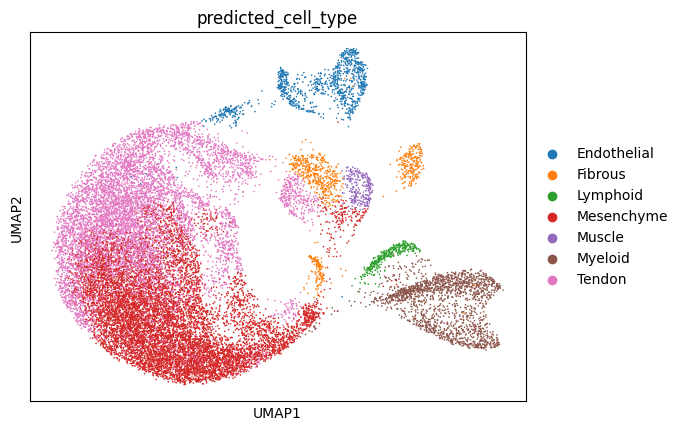

🔬 Input data has 17486 cells and 22224 genes
🔗 Matching reference genes in the model
🧬 17809 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [5]:
from celltypist.models import Model

model = Model.load('/lustre/scratch125/cellgen/behjati/lr26/snRNA/limb_hca_ref_model-all-broadanno.pkl')

preds = celltypist.annotate(
    adata_filtered,
    model=model,
    majority_voting=True
)

# Save predicted labels
adata_filtered.obs['predicted_cell_type'] = preds.predicted_labels['majority_voting']

# Visualize if you have UMAP
sc.pl.umap(adata_filtered, color='predicted_cell_type')

adata_tumor = adata_filtered[adata_filtered.obs['Label_fine'] == 'Tumor'].copy()

# Run prediction
preds_tumor = celltypist.annotate(adata_tumor, model=model, majority_voting=True)

# Save labels
adata_tumor.obs['predicted_cell_type'] = preds_tumor.predicted_labels['majority_voting']


In [ ]:
import celltypist
import scanpy as sc

# Subset tumor cells from your query dataset
adata_tumor = adata_filtered[adata_filtered.obs['Label_fine'] == 'OCT sample'].copy()

# Run CellTypist prediction
preds_tumor = celltypist.annotate(
    adata_tumor,
    model=model,
    majority_voting=True
)

# Save the predicted cell types
adata_tumor.obs['predicted_cell_type'] = preds_tumor.predicted_labels['majority_voting']

# Optional: visualize with UMAP if available
sc.pl.umap(adata_tumor, color='predicted_cell_type')